In [1]:
%load_ext burr.integrations.notebook

The notebook cell outputs will show logs produced by editing the `burr.core.application` logging for `_call_execute_method_pre_post`, which differ between sync and async implementations.

```python
# line 602
def _call_execute_method_pre_post(self, fn: CallableT) -> CallableT:
    @functools.wraps(fn)
    async def wrapper_async(app_self, *args, **kwargs):
        # We only run at the top level, so we decorate it if we're there
        await self.acall_pre(app_self)
        exc = None
        try:
            return await fn(app_self, *args, **kwargs)
        finally:
            logger.info(f"Async post start: {fn.__name__}")
            await self.acall_post(app_self, exc)
            logger.info(f"Async post end: {fn.__name__}")

    @functools.wraps(fn)
    def wrapper_sync(app_self, *args, **kwargs):
        self.call_pre(app_self)
        exc = None
        try:
            return fn(app_self, *args, **kwargs)
        finally:
            logger.info(f"sync post start: {fn.__name__}")
            self.call_post(app_self, exc)
            logger.info(f"sync post end: {fn.__name__}")

    return wrapper_async if inspect.iscoroutinefunction(fn) else wrapper_sync
```

In [2]:
import logging

logger = logging.getLogger("burr.core.application")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

1. Create an `Application` with synchronous actions

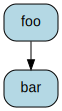

In [3]:
from burr.core import action, State, ApplicationBuilder

@action(reads=[], writes=["field1"])
def foo(state: State) -> State:
    return state.update(field1="value1")

@action(reads=["field1"], writes=["field2"])
def bar(state: State) -> State:
    value1 = state["field1"]
    return state.update(field2="value2")

def build_app():
    return  (
        ApplicationBuilder()
        .with_actions(foo, bar)
        .with_transitions(("foo", "bar"))
        .with_entrypoint("foo")
        .with_tracker(project="debugging")
        .build()
    )

build_app()

2. Run the `Application` with `.arun()` and setting a `halt_after` condition

In [4]:
app = build_app()
action_name, results, state = await app.arun(halt_after=["bar"])

sync post start: aiterate
sync post end: aiterate
Async post start: astep
Async post end: astep
Async post start: astep
Async post end: astep
Async post start: arun
Async post end: arun


3. View results in Burr UI. On `foo`, the state won't show the `field1` value. On `bar`, the state won't show `field2`.

In [5]:
%burr_ui

4. Now, running the `Application` with `.run()` will show `field1` and `field2` values. The two implementations are not equivalent.

In [6]:
app = build_app()
action_name, results, state = app.run(halt_after=["bar"])

sync post start: iterate
sync post end: iterate
sync post start: step
sync post end: step
sync post start: step
sync post end: step
sync post start: run
sync post end: run


5. If you were to do `halt_before`, the `field1` value still shows on `foo`. Then, `async` is not equivalent to "halting before". There's an operation that's happening in the wrong order

In [7]:
app = build_app()
action_name, results, state = app.run(halt_before=["bar"])

sync post start: iterate
sync post end: iterate
sync post start: step
sync post end: step
sync post start: run
sync post end: run
